<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using Glove
    and ML Models*</h1>

<h2 style="color:blue; background:pink; line-height:1.5">Import required libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

<h2 style="color:blue; background:pink; line-height:1.5">Loading Dataset which has extracted features and Preprocessed</h2>

**Dataset link:** https://drive.google.com/file/d/1rxPJHAvSXzOPEpIqmaAsXvhJK8p4K4JN/view?usp=sharing

**Preprocessed Dataset link:** https://drive.google.com/file/d/1gKfuAAzJRs-l-0ftJgb-NQj8-PQrLqtn/view?usp=sharing

In [2]:
df=pd.read_csv('data/feat_extr_data.csv')
df.head()

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Dataset information</h2>

In [3]:
df.shape

(49998, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question1           49998 non-null  object 
 1   question2           49998 non-null  object 
 2   is_duplicate        49998 non-null  int64  
 3   que1_len            49998 non-null  int64  
 4   que2_len            49998 non-null  int64  
 5   que1_num_words      49998 non-null  int64  
 6   que2_num_words      49998 non-null  int64  
 7   total_words         49998 non-null  int64  
 8   common_words        49998 non-null  int64  
 9   shared_words        49998 non-null  float64
 10  cwc_min             49998 non-null  float64
 11  cwc_max             49998 non-null  float64
 12  csc_min             49998 non-null  float64
 13  csc_max             49998 non-null  float64
 14  ctc_min             49998 non-null  float64
 15  ctc_max             49998 non-null  float64
 16  last

<h2 style="color:blue; background:pink; line-height:1.5">Missing values</h2>

In [5]:
df.isnull().sum()

question1             0
question2             0
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance check</h2>

In [6]:
class_balance=pd.DataFrame(df['is_duplicate'].value_counts()).reset_index()
class_balance.columns=["Class", "Count"]
class_balance['Percentage']=(class_balance['Count']/df.shape[0])*100
class_balance

,Class,Count,Percentage
0,1,25000,50.002
1,0,24998,49.998


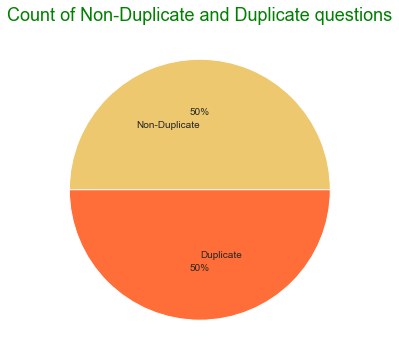

In [7]:
label=['Non-Duplicate', 'Duplicate'] 
color=sns.color_palette('rainbow')[4:6]
plt.figure(figsize=(6,6))
plt.pie(x=class_balance['Count'], labels=label, colors=color, autopct='%.0f%%' , labeldistance=0.5)
plt.title("Count of Non-Duplicate and Duplicate questions", fontsize=18, color='green');

<h2 style="color:blue; background:pink; line-height:1.5">Combine question1 and question2</h2>

In [8]:
data=df[['is_duplicate','question1','question2']]
data['combine_question']=data['question1']+" "+data['question2']
data.head(2)

,is_duplicate,question1,question2,combine_question
0,1,what minor would complement a computer science...,what is a good minor that will compliment a co...,what minor would complement a computer science...
1,1,how can i materialize an idea,what is the best way to materialize on an idea,how can i materialize an idea what is the best...


<h2 style="color:blue; background:pink; line-height:1.5">Input and output feaures</h2>

In [9]:
X=data.drop('is_duplicate', axis=1)
y=data['is_duplicate']
print(X.shape, y.shape)

(49998, 3) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Train Test Split</h2>

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("x train shape=", x_train.shape)
print("y train shape=", y_train.shape)
print("x test shape=", x_test.shape)
print("y test shape=", y_test.shape)

x train shape= (39998, 3)
y train shape= (39998,)
x test shape= (10000, 3)
y test shape= (10000,)


### No need of text preprocessing because we loaded clean data

<h2 style="color:blue; background:pink; line-height:1.5">Convert Text to Numerical Vectors using Pretrained GloVe</h2>

In [12]:
import gensim
print(gensim.__version__)
import gensim.downloader as api

4.3.1


In [13]:
wv=api.load('glove-twitter-50')

In [14]:
len(wv.index_to_key)

1193514

<h2 style="color:blue; background:pink; line-height:1.5">Tokenize question 1 and question 2 in both train and test set</h2>

In [15]:
x_train['tokenised_que']=x_train['combine_question'].apply(lambda sent : sent.split())
x_test['tokenised_que']=x_test['combine_question'].apply(lambda sent : sent.split())
x_train.head(2)

,question1,question2,combine_question,tokenised_que
39085,which laptop should i buy under 60k,which laptop should i buy under 60k,which laptop should i buy under 60k which lapt...,"[which, laptop, should, i, buy, under, 60k, wh..."
30892,how hair grow after hair transplant surgery,how long does a hair transplant surgery take,how hair grow after hair transplant surgery ho...,"[how, hair, grow, after, hair, transplant, sur..."


In [16]:
x_test.head(2)

,question1,question2,combine_question,tokenised_que
33552,i am skinny fat what strategy should i follow ...,what will be future for r profile within few y...,i am skinny fat what strategy should i follow ...,"[i, am, skinny, fat, what, strategy, should, i..."
9427,do rich people worry about anything,what do wealthy people worry about,do rich people worry about anything what do we...,"[do, rich, people, worry, about, anything, wha..."


<h2 style="color:blue; background:pink; line-height:1.5">Drop out of vocabulary words</h2>

In [19]:
def document_vector(doc, keyed_vectors):
    vocab_tokens=[word for word in doc if word in keyed_vectors.index_to_key]
    return np.mean(keyed_vectors.__getitem__(vocab_tokens), axis=0)

x_train['doc_vector']=x_train['tokenised_que'].apply(lambda x : document_vector(x, wv))
x_test['doc_vector']=x_test['tokenised_que'].apply(lambda x : document_vector(x, wv))
x_train.head(2)

,question1,question2,combine_question,tokenised_que,doc_vector
39085,which laptop should i buy under 60k,which laptop should i buy under 60k,which laptop should i buy under 60k which lapt...,"[which, laptop, should, i, buy, under, 60k, wh...","[-0.14728968, 0.14114876, -0.11543834, -0.0281..."
30892,how hair grow after hair transplant surgery,how long does a hair transplant surgery take,how hair grow after hair transplant surgery ho...,"[how, hair, grow, after, hair, transplant, sur...","[-0.4859347, -0.224695, -0.075187884, -0.26588..."


In [20]:
x_test.head(2)

,question1,question2,combine_question,tokenised_que,doc_vector
33552,i am skinny fat what strategy should i follow ...,what will be future for r profile within few y...,i am skinny fat what strategy should i follow ...,"[i, am, skinny, fat, what, strategy, should, i...","[-0.0053916345, 0.0038385887, -0.06900545, -0...."
9427,do rich people worry about anything,what do wealthy people worry about,do rich people worry about anything what do we...,"[do, rich, people, worry, about, anything, wha...","[0.5303995, 0.3425142, -0.05356201, 0.33874, -..."


<h2 style="color:blue; background:pink; line-height:1.5">Final Training and Testing Input data</h2>

In [21]:
x_train=list(x_train['doc_vector'])
x_test=list(x_test['doc_vector'])
x_train[1]

array([-0.4859347 , -0.224695  , -0.07518788, -0.26588246,  0.05303352,
       -0.24218853,  0.7209847 ,  0.04958791, -0.13588183,  0.01300734,
       -0.13278641, -0.41828325, -4.1051664 ,  0.3920442 , -0.09572928,
        0.28764734, -0.10601326, -0.29080328, -0.33808786, -0.5498167 ,
       -0.29559   ,  0.5076881 ,  0.11771228,  0.23038414, -0.14262213,
        0.7721395 , -0.01161353,  0.55617404,  0.14723572,  0.18185733,
       -0.30316526, -0.12574887, -0.0055846 , -0.60573125,  0.06488951,
        0.3739986 , -0.11965729,  0.40520602,  0.09362666,  0.17933334,
       -0.6329209 , -0.02413607,  0.23115869,  0.28090504,  0.534548  ,
       -0.75570744,  0.3039913 ,  0.22927652, -0.18706936,  0.04393585],
      dtype=float32)

In [22]:
x_test[1]

array([ 0.5303995 ,  0.3425142 , -0.05356201,  0.33874   , -0.04516114,
        0.20555168,  0.6659558 ,  0.06863333,  0.10900066,  0.35232663,
       -0.31585065, -0.22159068, -4.9764333 , -0.05170734, -0.38774335,
        0.02752433, -0.22470416, -0.39826468,  0.07516142, -0.36851832,
        0.10129017,  0.0483425 , -0.02053583,  0.36733297, -0.09283283,
        0.57455164,  0.5189917 ,  0.3091925 ,  0.15283665, -0.5050875 ,
        0.21865948, -0.08279916,  0.01122583,  0.35314   , -0.19996317,
        0.42614248, -0.2794591 , -0.10605707, -0.28483525, -0.18628241,
       -0.6807851 ,  0.4144651 ,  0.5030428 , -0.29857966, -0.11928884,
       -0.29761663,  0.2095514 ,  0.52496773, -0.33827516,  0.03742767],
      dtype=float32)

<h2 style="color:blue; background:pink; line-height:1.5">Building model</h2>

<h2 style="color:blue; background:pink;">Set Experiment<h2>

In [23]:
import mlflow
mlflow.set_experiment("Advance_approach_using_pre_trained_models")

<Experiment: artifact_location='file:///D:/DATA%20SCIENCE%20Internship%20with%20Innomatics/Final_%20Project_Quora_Question_Pair_Similarity/mlruns/591167485821976991', creation_time=1685863390057, experiment_id='591167485821976991', last_update_time=1685863390057, lifecycle_stage='active', name='Advance_approach_using_pre_trained_models', tags={}>

<h2 style="color:blue; background:lightgreen; line-height:1">1. Logistic Regression<h2>

----------------------------------------------------------
Acuuracy=0.621
Precission=0.6265406737880033
Recall=0.6073277578653923
F1 Score=0.6167846309403439
----------------------------------------------------------
Confusion Matrix=



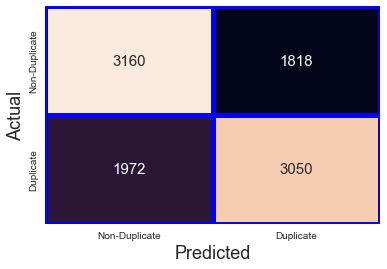

----------------------------------------------------------
Out of 10000 testing values 3790 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.62      0.63      0.63      4978
           1       0.63      0.61      0.62      5022

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000

----------------------------------------------------------


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Logistic glove")
    
    log_regression=LogisticRegression()
    log_regression.fit(x_train,y_train)
    pickle.dump(log_regression, open("resources_advance_approach_using_pre_trained_model/logistic_regression_glove.pkl","wb"))
    
    y_pred=log_regression.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/log_reg_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(log_regression, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/log_reg_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">2. Naive Bayes<h2>

----------------------------------------------------------
Acuuracy=0.6149
Precission=0.6349389260198203
Recall=0.5485862206292313
F1 Score=0.5886123277427626
----------------------------------------------------------
Confusion Matrix=



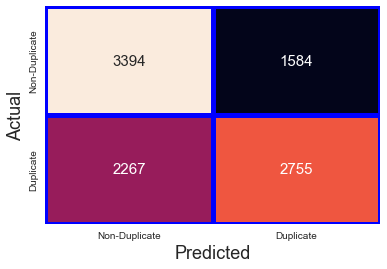

----------------------------------------------------------
Out of 10000 testing values 3851 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.60      0.68      0.64      4978
           1       0.63      0.55      0.59      5022

    accuracy                           0.61     10000
   macro avg       0.62      0.62      0.61     10000
weighted avg       0.62      0.61      0.61     10000

----------------------------------------------------------


In [26]:
from sklearn.naive_bayes import GaussianNB
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Naive Bayes glove")
    
    naive_classifier=GaussianNB()
    naive_classifier.fit(x_train,y_train)
    pickle.dump(naive_classifier, open("resources_advance_approach_using_pre_trained_model/naive_glove.pkl","wb"))
    
    y_pred=naive_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/naive_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(naive_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/naive_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">3. Decision Tree</h2>

----------------------------------------------------------
Acuuracy=0.6046
Precission=0.6077481840193705
Recall=0.5997610513739546
F1 Score=0.6037282020444978
----------------------------------------------------------
Confusion Matrix=



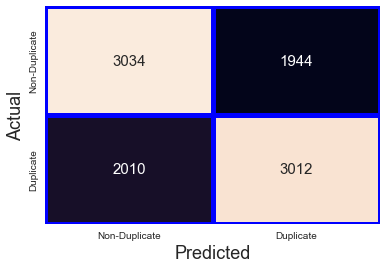

----------------------------------------------------------
Out of 10000 testing values 3954 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.60      0.61      0.61      4978
           1       0.61      0.60      0.60      5022

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000

----------------------------------------------------------


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Decision Tree glove")
    
    dt_classifier=DecisionTreeClassifier()
    dt_classifier.fit(x_train,y_train)
    pickle.dump(dt_classifier, open("resources_advance_approach_using_pre_trained_model/decision_tree_glove.pkl","wb"))
    
    y_pred=dt_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/decision_tree_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(dt_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/decision_tree_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">4. Random Forest</h2>

----------------------------------------------------------
Acuuracy=0.704
Precission=0.7078629032258065
Recall=0.6991238550378336
F1 Score=0.7034662392306151
----------------------------------------------------------
Confusion Matrix=



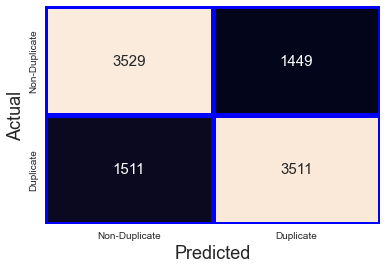

----------------------------------------------------------
Out of 10000 testing values 2960 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      4978
           1       0.71      0.70      0.70      5022

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

----------------------------------------------------------


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest glove")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    pickle.dump(rf_classifier, open("resources_advance_approach_using_pre_trained_model/random_forest_glove.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/random_forest_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/random_forest_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">5. Gradient Boosting</h2>

----------------------------------------------------------
Acuuracy=0.6706
Precission=0.6842217484008529
Recall=0.6389884508164078
F1 Score=0.660831960461285
----------------------------------------------------------
Confusion Matrix=



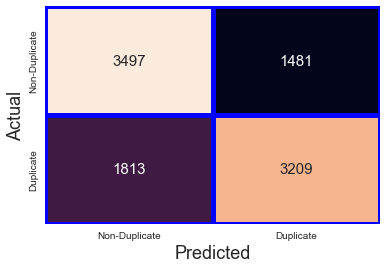

----------------------------------------------------------
Out of 10000 testing values 3294 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.66      0.70      0.68      4978
           1       0.68      0.64      0.66      5022

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

----------------------------------------------------------


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Gradient Boost word2vec")
    
    gb_classifier=GradientBoostingClassifier()
    gb_classifier.fit(x_train,y_train)
    pickle.dump(gb_classifier, open("resources_advance_approach_using_pre_trained_model/gradient_boostig_glove.pkl","wb"))
    
    y_pred=gb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/gradient_boost_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(gb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/gradient_boost_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">6. Ada Boost</h2>

----------------------------------------------------------
Acuuracy=0.6421
Precission=0.6523115896136795
Recall=0.6152927120669056
F1 Score=0.6332616046726098
----------------------------------------------------------
Confusion Matrix=



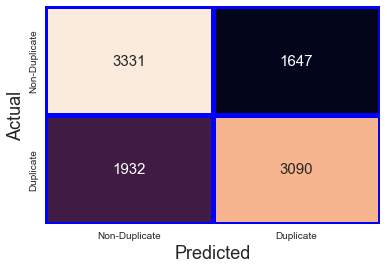

----------------------------------------------------------
Out of 10000 testing values 3579 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      4978
           1       0.65      0.62      0.63      5022

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000

----------------------------------------------------------


In [30]:
from sklearn.ensemble import AdaBoostClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Ada Boost glove")
    
    ada_classifier=AdaBoostClassifier()
    ada_classifier.fit(x_train,y_train)
    pickle.dump(ada_classifier, open("resources_advance_approach_using_pre_trained_model/ada_boosting_glove.pkl","wb"))
    
    y_pred=ada_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/ada_boost_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(ada_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/ada_boost_glove_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">7. XG Boost</h2>

----------------------------------------------------------
Acuuracy=0.6839
Precission=0.6911070034914767
Recall=0.6700517722023098
F1 Score=0.6804165402891517
----------------------------------------------------------
Confusion Matrix=



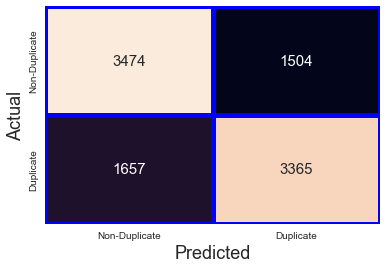

----------------------------------------------------------
Out of 10000 testing values 3161 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.68      0.70      0.69      4978
           1       0.69      0.67      0.68      5022

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000

----------------------------------------------------------


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost glove")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    pickle.dump(xgb_classifier, open("resources_advance_approach_using_pre_trained_model/xgboost_word2vec.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/xgboost_glove_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/xgboost_glove_conf_matrix.png")

### Inference:
 **Accuracy of Random Forest model is high(71%).**